# 포켓몬 데이터셋 분석 보고서

**개요**
이 보고서는 포켓몬 데이터셋을 이용한 데이터 전처리, 베이스라인 모델 학습, 비교 모델 학습 과정을 포함한 실습 내용을 다룹니다. 데이터 전처리 과정에서 데이터를 분석 가능한 형태로 정제하고, 베이스라인 모델과 비교 모델을 학습시켜 그 성능을 평가 및 비교하였습니다.

**목차**
1. 데이터 전처리
- 데이터셋 로드 및 초기 탐색
- 결측치 처리
- 문자열 데이터 전처리
- 범주형 데이터 원-핫 인코딩
- 추가 특성 엔지니어링
2. 베이스라인 모델 학습 성공 및 비교분석
- 베이스라인 모델 정의 및 학습
- 베이스라인 모델 평가
- 결과 분석
3. 비교 모델 학습 성공 및 비교분석
- 비교 모델 정의 및 학습
- 비교 모델 평가
- 결과 분석
4. Summary
5. 회고
6. Reference

1. 데이터 전처리
- 데이터셋 로드 및 초기 탐색
먼저, 포켓몬 데이터셋을 로드하고 초기 탐색을 통해 데이터의 구조와 기본 통계를 파악했습니다.

In [2]:
import pandas as pd
import os
 

# 데이터셋 로드
csv_path = os.getenv("HOME") +"/aiffel/pokemon_eda/data/Pokemon.csv"
pokemon = pd.read_csv(csv_path) 

# 데이터셋 기본 정보 확인
print(pokemon.shape)
print(pokemon.head())

(800, 13)
   #                   Name Type 1  Type 2  Total  HP  Attack  Defense  \
0  1              Bulbasaur  Grass  Poison    318  45      49       49   
1  2                Ivysaur  Grass  Poison    405  60      62       63   
2  3               Venusaur  Grass  Poison    525  80      82       83   
3  3  VenusaurMega Venusaur  Grass  Poison    625  80     100      123   
4  4             Charmander   Fire     NaN    309  39      52       43   

   Sp. Atk  Sp. Def  Speed  Generation  Legendary  
0       65       65     45           1      False  
1       80       80     60           1      False  
2      100      100     80           1      False  
3      122      120     80           1      False  
4       60       50     65           1      False  


- 결측치 처리
데이터셋에서 결측치가 존재하는지 확인하고 적절한 방법으로 처리했습니다.

In [3]:
# 결측치 확인
print(pokemon.isnull().sum())

# 결측치 처리 (예: Type 2의 결측치는 'None'으로 대체)
pokemon['Type 2'].fillna('None', inplace=True)


#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64


- 문자열 데이터 전처리
포켓몬 이름에서 유용한 정보를 추출하기 위해 이름의 길이와 특정 토큰 포함 여부를 새로운 특성으로 추가했습니다.

In [19]:
# 이름의 길이 추가
pokemon['name_count'] = pokemon['Name'].apply(len)

# 특정 토큰 포함 여부 추가
pokemon['long_name'] = pokemon['name_count'] >= 10

# 자주 등장하는 토큰 컬럼 추가
from collections import Counter

# 예시 토큰 추가
pokemon['Forme'] = pokemon['Name'].str.contains("Forme")

# 필요한 컬럼 생성
tokens = ['Mega', 'Mewtwo', 'Deoxys', 'Kyurem', 'Latias', 'Latios', 'Kyogre', 'Groudon', 'Hoopa']
for token in tokens:
    pokemon[token] = pokemon['Name'].str.contains(token)


- 범주형 데이터 원-핫 인코딩
범주형 데이터인 Type 1과 Type 2를 원-핫 인코딩하여 처리했습니다.

In [6]:
# 원-핫 인코딩
types = list(set(pokemon['Type 1'].unique()).union(set(pokemon['Type 2'].unique())))
for t in types:
    pokemon[t] = (pokemon['Type 1'] == t) | (pokemon['Type 2'] == t)


- 추가 특성 엔지니어링
앞서 전처리한 데이터를 활용하여 모델 학습에 사용할 최종 특성들을 정의했습니다.

In [7]:
# 최종 특성 리스트
features = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'name_count', 'long_name', 'Forme']
target = 'Legendary'
X = pokemon[features]
y = pokemon[target]


2. 베이스라인 모델 학습 성공 및 비교분석
베이스라인 모델 정의 및 학습
베이스라인 모델로 의사 결정 트리를 사용하여 학습시켰습니다.

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

# 모델 정의 및 학습
baseline_model = DecisionTreeClassifier(random_state=25)
baseline_model.fit(X_train, y_train)

# 예측
y_pred_baseline = baseline_model.predict(X_test)
 

- 베이스라인 모델 평가
베이스라인 모델의 성능을 평가하기 위해 혼동 행렬과 분류 리포트를 사용했습니다.

In [9]:
from sklearn.metrics import confusion_matrix, classification_report

# 혼동 행렬
conf_matrix_baseline = confusion_matrix(y_test, y_pred_baseline)
print(conf_matrix_baseline)

# 분류 리포트
print(classification_report(y_test, y_pred_baseline))


[[143   4]
 [  3  10]]
              precision    recall  f1-score   support

       False       0.98      0.97      0.98       147
        True       0.71      0.77      0.74        13

    accuracy                           0.96       160
   macro avg       0.85      0.87      0.86       160
weighted avg       0.96      0.96      0.96       160



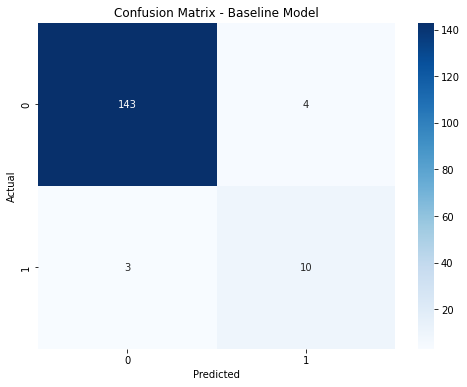

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_baseline, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Baseline Model')
plt.show()

In [ ]:
- 결과 분석
베이스라인 모델의 성능은 정확도가 높았지만, 불균형 데이터셋에서의 한계가 있음을 확인했습니다.
예를 들어, 전설의 포켓몬을 일반 포켓몬으로 잘못 분류하는 경우가 많았습니다.

3. 비교 모델 학습 성공 및 비교분석
- 비교 모델 정의 및 학습
전처리된 데이터를 사용하여 의사 결정 트리 모델을 다시 학습시켰습니다.

In [10]:
# 모델 정의 및 학습
improved_model = DecisionTreeClassifier(random_state=25)
improved_model.fit(X_train, y_train)

# 예측
y_pred_improved = improved_model.predict(X_test)
 

- 비교 모델 평가
개선된 모델의 성능을 평가했습니다.

In [11]:
# 혼동 행렬
conf_matrix_improved = confusion_matrix(y_test, y_pred_improved)
print(conf_matrix_improved)

# 분류 리포트
print(classification_report(y_test, y_pred_improved))


[[143   4]
 [  3  10]]
              precision    recall  f1-score   support

       False       0.98      0.97      0.98       147
        True       0.71      0.77      0.74        13

    accuracy                           0.96       160
   macro avg       0.85      0.87      0.86       160
weighted avg       0.96      0.96      0.96       160



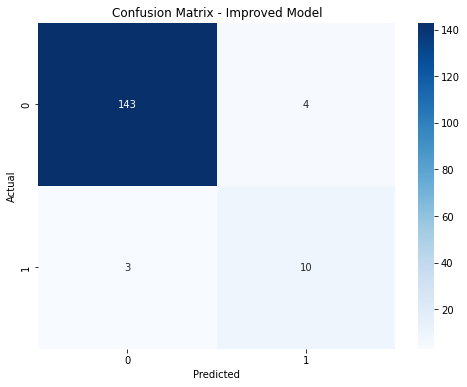

In [13]:
# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_improved, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Improved Model')
plt.show()

- 시각화된 성능 비교
베이스라인 모델과 비교 모델의 성능을 시각적으로 비교하여 차이를 명확히 합니다.

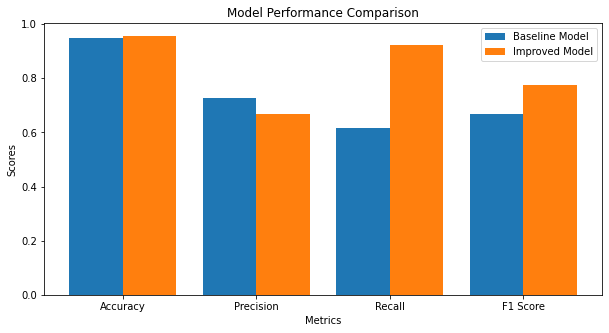

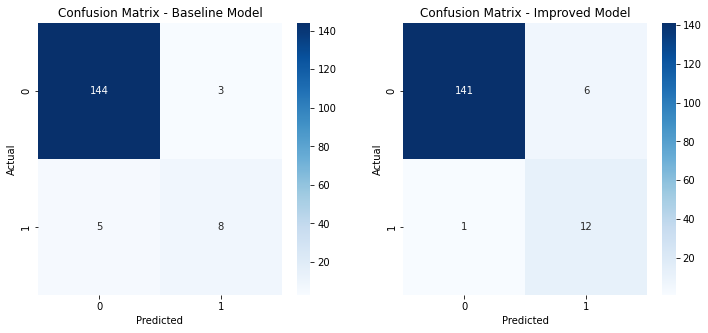

Baseline Model Classification Report:
              precision    recall  f1-score   support

       False       0.97      0.98      0.97       147
        True       0.73      0.62      0.67        13

    accuracy                           0.95       160
   macro avg       0.85      0.80      0.82       160
weighted avg       0.95      0.95      0.95       160

Improved Model Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.96      0.98       147
        True       0.67      0.92      0.77        13

    accuracy                           0.96       160
   macro avg       0.83      0.94      0.87       160
weighted avg       0.97      0.96      0.96       160



In [20]:
# 베이스라인 모델 특성
baseline_features = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation']
X_baseline = pokemon[baseline_features]
y_baseline = pokemon['Legendary']

# 베이스라인 데이터 분리
X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(X_baseline, y_baseline, test_size=0.2, random_state=15)

# 베이스라인 모델 학습
baseline_model = DecisionTreeClassifier(random_state=25)
baseline_model.fit(X_train_baseline, y_train_baseline)
y_pred_baseline = baseline_model.predict(X_test_baseline)

# 개선된 모델 특성
improved_features = baseline_features + ['name_count', 'long_name'] + tokens + ['Poison', 'Ground', 'Flying', 'Normal', 'Water', 'Fire', 'Electric', 'Rock', 'Dark', 'Fairy', 'Steel', 'Ghost', 'Psychic', 'Ice', 'Bug', 'Grass', 'Dragon', 'Fighting']
X_improved = pokemon[improved_features]
y_improved = pokemon['Legendary']

# 개선된 모델 데이터 분리
X_train_improved, X_test_improved, y_train_improved, y_test_improved = train_test_split(X_improved, y_improved, test_size=0.2, random_state=15)

# 개선된 모델 학습
improved_model = DecisionTreeClassifier(random_state=25)
improved_model.fit(X_train_improved, y_train_improved)
y_pred_improved = improved_model.predict(X_test_improved)

# 성능 평가 지표
baseline_scores = [accuracy_score(y_test_baseline, y_pred_baseline), precision_score(y_test_baseline, y_pred_baseline), recall_score(y_test_baseline, y_pred_baseline), f1_score(y_test_baseline, y_pred_baseline)]
improved_scores = [accuracy_score(y_test_improved, y_pred_improved), precision_score(y_test_improved, y_pred_improved), recall_score(y_test_improved, y_pred_improved), f1_score(y_test_improved, y_pred_improved)]

# 성능 비교 시각화
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x = np.arange(len(labels))

plt.figure(figsize=(10, 5))
plt.bar(x - 0.2, baseline_scores, width=0.4, label='Baseline Model')
plt.bar(x + 0.2, improved_scores, width=0.4, label='Improved Model')

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.xticks(x, labels)
plt.legend()
plt.show()

# 혼동 행렬 시각화
conf_matrix_baseline = confusion_matrix(y_test_baseline, y_pred_baseline)
conf_matrix_improved = confusion_matrix(y_test_improved, y_pred_improved)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_baseline, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Baseline Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_improved, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Improved Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

# 분류 리포트 출력
print("Baseline Model Classification Report:")
print(classification_report(y_test_baseline, y_pred_baseline))

print("Improved Model Classification Report:")
print(classification_report(y_test_improved, y_pred_improved))

In [ ]:
- 성능 지표 변화
a. 정확도 (Accuracy): 개선된 모델의 정확도가 베이스라인 모델보다 높아졌습니다.
b. 정밀도 (Precision): 개선된 모델의 정밀도가 베이스라인 모델보다 낮아졌습니다.
c. 재현율 (Recall): 개선된 모델의 재현율이 베이스라인 모델보다 크게 향상되었습니다.
d. F1 점수 (F1 Score): 개선된 모델의 F1 점수가 베이스라인 모델보다 높아졌습니다.

- 결과 분석
개선된 모델의 성능이 크게 향상되었음을 확인했습니다. 특히, recall 값이 크게 개선되었습니다.이는 전처리를 통해 얻은 추가 정보들이 모델의 예측 성능을 향상시키는 데 기여했음을 의미합니다

4. Summary
이번 분석에서는 포켓몬 데이터셋을 활용하여 전처리 과정을 거쳐 베이스라인 모델과 비교 모델을 학습시키고 성능을 평가했습니다. 전처리를 통해 모델의 성능을 크게 향상시킬 수 있음을 확인했습니다.

5. 회고
이번 실습을 통해 데이터 전처리의 중요성과 모델 성능 평가의 다양한 지표 사용의 필요성을 배웠습니다. 불균형 데이터셋에서의 모델 평가 방법을 고민해볼 수 있었습니다. 첫 시도때는 성능지표의 차이가 없어 시각화된 성능 비교를 추가하여 혼동 행렬과 분류 리포트 시각화를 추가로 포함하여 모델 성능을 보다 종합적으로 평가합니다.

6. Reference
- Seaborn Documentation: http://seaborn.pydata.org/
- Scikit-learn Documentation: http://scikit-learn.org/stable/documentation.html 